# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.466779698324851 -2.606996774785296
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [167]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [168]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [169]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [170]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [171]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [172]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [173]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [174]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.reshape(rewards[-1], [1])])
    Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [175]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [176]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [177]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [178]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [179]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [180]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 rate:0.0200 gloss:-0.0230 dloss:1.3497 dlossR:0.6569 dlossQ:0.6928
Episode:1 meanR:10.5000 rate:0.0220 gloss:0.0692 dloss:1.4243 dlossR:0.7323 dlossQ:0.6920
Episode:2 meanR:9.6667 rate:0.0160 gloss:0.0483 dloss:1.4121 dlossR:0.7195 dlossQ:0.6926
Episode:3 meanR:9.7500 rate:0.0200 gloss:0.0057 dloss:1.3794 dlossR:0.6863 dlossQ:0.6931
Episode:4 meanR:9.6000 rate:0.0180 gloss:-0.0567 dloss:1.3295 dlossR:0.6373 dlossQ:0.6922
Episode:5 meanR:9.5000 rate:0.0180 gloss:-0.1019 dloss:1.2920 dlossR:0.6020 dlossQ:0.6899
Episode:6 meanR:9.4286 rate:0.0180 gloss:-0.1405 dloss:1.2639 dlossR:0.5765 dlossQ:0.6874
Episode:7 meanR:9.3750 rate:0.0180 gloss:-0.1727 dloss:1.2466 dlossR:0.5612 dlossQ:0.6854
Episode:8 meanR:9.4444 rate:0.0200 gloss:-0.2228 dloss:1.2186 dlossR:0.5378 dlossQ:0.6808
Episode:9 meanR:10.9000 rate:0.0480 gloss:-0.1578 dloss:1.2623 dlossR:0.5749 dlossQ:0.6875
Episode:10 meanR:12.2727 rate:0.0520 gloss:-0.1433 dloss:1.2714 dlossR:0.5827 dlossQ:0.6887
Episode:

Episode:95 meanR:44.7396 rate:0.1820 gloss:-1.1196 dloss:0.9560 dlossR:0.4945 dlossQ:0.4616
Episode:96 meanR:44.9278 rate:0.1260 gloss:-0.9906 dloss:0.8808 dlossR:0.3866 dlossQ:0.4941
Episode:97 meanR:44.8776 rate:0.0800 gloss:-1.1698 dloss:0.7820 dlossR:0.3117 dlossQ:0.4703
Episode:98 meanR:45.0606 rate:0.1260 gloss:-1.0833 dloss:0.8485 dlossR:0.3822 dlossQ:0.4663
Episode:99 meanR:45.1400 rate:0.1060 gloss:-1.0734 dloss:0.8178 dlossR:0.3482 dlossQ:0.4696
Episode:100 meanR:45.6700 rate:0.1260 gloss:-1.0026 dloss:0.8762 dlossR:0.3852 dlossQ:0.4910
Episode:101 meanR:45.7900 rate:0.0460 gloss:-1.0998 dloss:0.7095 dlossR:0.2435 dlossQ:0.4659
Episode:102 meanR:45.9000 rate:0.0380 gloss:-1.1287 dloss:0.6913 dlossR:0.2252 dlossQ:0.4662
Episode:103 meanR:45.9200 rate:0.0240 gloss:-1.3178 dloss:0.6053 dlossR:0.1707 dlossQ:0.4346
Episode:104 meanR:45.9600 rate:0.0260 gloss:-1.2815 dloss:0.6137 dlossR:0.1795 dlossQ:0.4341
Episode:105 meanR:45.9800 rate:0.0220 gloss:-1.2878 dloss:0.6107 dlossR:0.1

Episode:188 meanR:36.9800 rate:0.1320 gloss:-1.2463 dloss:0.8193 dlossR:0.3951 dlossQ:0.4243
Episode:189 meanR:38.9400 rate:0.4140 gloss:-1.1607 dloss:1.4509 dlossR:0.9963 dlossQ:0.4545
Episode:190 meanR:39.8000 rate:0.1980 gloss:-1.1944 dloss:0.9515 dlossR:0.5216 dlossQ:0.4299
Episode:191 meanR:40.7300 rate:0.2180 gloss:-1.1666 dloss:0.9982 dlossR:0.5586 dlossQ:0.4395
Episode:192 meanR:41.1600 rate:0.1240 gloss:-1.3363 dloss:0.7681 dlossR:0.3776 dlossQ:0.3906
Episode:193 meanR:41.3400 rate:0.0820 gloss:-1.3545 dloss:0.6785 dlossR:0.2886 dlossQ:0.3899
Episode:194 meanR:41.5500 rate:0.1340 gloss:-1.2691 dloss:0.8074 dlossR:0.3963 dlossQ:0.4111
Episode:195 meanR:41.1600 rate:0.1040 gloss:-1.2857 dloss:0.7412 dlossR:0.3355 dlossQ:0.4057
Episode:196 meanR:40.8100 rate:0.0560 gloss:-1.2918 dloss:0.6484 dlossR:0.2385 dlossQ:0.4099
Episode:197 meanR:40.6500 rate:0.0480 gloss:-1.2880 dloss:0.6304 dlossR:0.2221 dlossQ:0.4082
Episode:198 meanR:40.2900 rate:0.0540 gloss:-1.2467 dloss:0.6630 dloss

Episode:278 meanR:35.6000 rate:0.0360 gloss:-1.4796 dloss:0.5437 dlossR:0.1774 dlossQ:0.3663
Episode:279 meanR:35.5500 rate:0.0300 gloss:-1.4843 dloss:0.5308 dlossR:0.1620 dlossQ:0.3687
Episode:280 meanR:35.7100 rate:0.0720 gloss:-1.5281 dloss:0.6028 dlossR:0.2604 dlossQ:0.3424
Episode:281 meanR:36.0300 rate:0.0960 gloss:-1.5139 dloss:0.6588 dlossR:0.3169 dlossQ:0.3418
Episode:282 meanR:36.2800 rate:0.0700 gloss:-1.5435 dloss:0.5972 dlossR:0.2556 dlossQ:0.3416
Episode:283 meanR:36.3100 rate:0.0400 gloss:-1.5920 dloss:0.5200 dlossR:0.1800 dlossQ:0.3400
Episode:284 meanR:36.7400 rate:0.1120 gloss:-1.5025 dloss:0.6979 dlossR:0.3544 dlossQ:0.3434
Episode:285 meanR:37.0600 rate:0.0920 gloss:-1.5261 dloss:0.6466 dlossR:0.3076 dlossQ:0.3390
Episode:286 meanR:37.0300 rate:0.0600 gloss:-1.5398 dloss:0.5740 dlossR:0.2315 dlossQ:0.3425
Episode:287 meanR:36.2100 rate:0.0360 gloss:-1.6100 dloss:0.5078 dlossR:0.1685 dlossQ:0.3393
Episode:288 meanR:35.6500 rate:0.0200 gloss:-1.6866 dloss:0.4819 dloss

Episode:375 meanR:33.9900 rate:0.0800 gloss:-1.4158 dloss:0.6477 dlossR:0.2813 dlossQ:0.3664
Episode:376 meanR:35.4800 rate:0.3300 gloss:-1.3068 dloss:1.2416 dlossR:0.8430 dlossQ:0.3986
Episode:377 meanR:35.3800 rate:0.0200 gloss:-1.8139 dloss:0.4877 dlossR:0.1151 dlossQ:0.3725
Episode:378 meanR:35.6500 rate:0.0900 gloss:-1.4264 dloss:0.6663 dlossR:0.3031 dlossQ:0.3632
Episode:379 meanR:35.7000 rate:0.0400 gloss:-1.4160 dloss:0.5698 dlossR:0.1921 dlossQ:0.3777
Episode:380 meanR:35.5200 rate:0.0360 gloss:-1.4177 dloss:0.5625 dlossR:0.1826 dlossQ:0.3799
Episode:381 meanR:35.1500 rate:0.0220 gloss:-1.3729 dloss:0.5611 dlossR:0.1513 dlossQ:0.4098
Episode:382 meanR:34.9800 rate:0.0360 gloss:-1.4369 dloss:0.5558 dlossR:0.1809 dlossQ:0.3749
Episode:383 meanR:34.9300 rate:0.0300 gloss:-1.4189 dloss:0.5535 dlossR:0.1677 dlossQ:0.3858
Episode:384 meanR:34.6100 rate:0.0480 gloss:-1.4282 dloss:0.5799 dlossR:0.2095 dlossQ:0.3704
Episode:385 meanR:34.6900 rate:0.1080 gloss:-1.4372 dloss:0.7028 dloss

Episode:465 meanR:109.5600 rate:0.1180 gloss:0.2952 dloss:1.5000 dlossR:0.8272 dlossQ:0.6727
Episode:466 meanR:109.9400 rate:0.1000 gloss:0.2641 dloss:1.4978 dlossR:0.8210 dlossQ:0.6768
Episode:467 meanR:110.2100 rate:0.0720 gloss:0.2010 dloss:1.4821 dlossR:0.7984 dlossQ:0.6836
Episode:468 meanR:110.5600 rate:0.0920 gloss:0.2213 dloss:1.4789 dlossR:0.7972 dlossQ:0.6817
Episode:469 meanR:110.8100 rate:0.0740 gloss:0.2259 dloss:1.4948 dlossR:0.8141 dlossQ:0.6807
Episode:470 meanR:110.9300 rate:0.0540 gloss:0.1512 dloss:1.4627 dlossR:0.7751 dlossQ:0.6876
Episode:471 meanR:111.0500 rate:0.0760 gloss:0.2029 dloss:1.4785 dlossR:0.7954 dlossQ:0.6831
Episode:472 meanR:111.2600 rate:0.0760 gloss:0.1513 dloss:1.4471 dlossR:0.7593 dlossQ:0.6878
Episode:473 meanR:111.2700 rate:0.0520 gloss:0.1212 dloss:1.4437 dlossR:0.7543 dlossQ:0.6895
Episode:474 meanR:111.3500 rate:0.0580 gloss:0.0783 dloss:1.4121 dlossR:0.7203 dlossQ:0.6919
Episode:475 meanR:111.2100 rate:0.0520 gloss:0.0544 dloss:1.4000 dloss

Episode:554 meanR:85.8300 rate:0.1300 gloss:-1.1317 dloss:0.8424 dlossR:0.3887 dlossQ:0.4537
Episode:555 meanR:85.8300 rate:1.0000 gloss:-0.4083 dloss:2.5463 dlossR:1.7899 dlossQ:0.7565
Episode:556 meanR:88.9600 rate:1.0000 gloss:-0.3657 dloss:2.5048 dlossR:1.7381 dlossQ:0.7667
Episode:557 meanR:88.9600 rate:1.0000 gloss:-0.3079 dloss:2.4485 dlossR:1.6689 dlossQ:0.7796
Episode:558 meanR:88.9600 rate:1.0000 gloss:-0.2240 dloss:2.3657 dlossR:1.5707 dlossQ:0.7950
Episode:559 meanR:88.9600 rate:1.0000 gloss:-0.1635 dloss:2.3050 dlossR:1.5013 dlossQ:0.8037
Episode:560 meanR:92.1000 rate:1.0000 gloss:-0.0952 dloss:2.2355 dlossR:1.4246 dlossQ:0.8109
Episode:561 meanR:94.5300 rate:1.0000 gloss:-0.0334 dloss:2.1719 dlossR:1.3568 dlossQ:0.8150
Episode:562 meanR:97.0900 rate:1.0000 gloss:0.0303 dloss:2.1051 dlossR:1.2887 dlossQ:0.8164
Episode:563 meanR:101.3400 rate:1.0000 gloss:0.0927 dloss:2.0389 dlossR:1.2235 dlossQ:0.8154
Episode:564 meanR:105.2100 rate:1.0000 gloss:0.1507 dloss:1.9768 dlossR

Episode:642 meanR:254.9200 rate:0.1340 gloss:0.0784 dloss:1.3801 dlossR:0.6864 dlossQ:0.6937
Episode:643 meanR:255.2300 rate:0.1840 gloss:0.1066 dloss:1.3786 dlossR:0.6844 dlossQ:0.6943
Episode:644 meanR:255.9800 rate:0.3120 gloss:0.2145 dloss:1.3863 dlossR:0.6932 dlossQ:0.6931
Episode:645 meanR:255.5000 rate:0.1900 gloss:0.1187 dloss:1.3819 dlossR:0.6881 dlossQ:0.6939
Episode:646 meanR:252.3400 rate:0.1560 gloss:0.0862 dloss:1.3773 dlossR:0.6831 dlossQ:0.6941
Episode:647 meanR:252.5700 rate:0.1980 gloss:0.1190 dloss:1.3802 dlossR:0.6859 dlossQ:0.6943
Episode:648 meanR:249.5800 rate:0.1380 gloss:0.0639 dloss:1.3719 dlossR:0.6776 dlossQ:0.6944
Episode:649 meanR:249.8300 rate:0.1560 gloss:0.0893 dloss:1.3786 dlossR:0.6846 dlossQ:0.6940
Episode:650 meanR:250.0400 rate:0.1480 gloss:0.0748 dloss:1.3742 dlossR:0.6799 dlossQ:0.6943
Episode:651 meanR:249.8800 rate:0.1140 gloss:0.0414 dloss:1.3674 dlossR:0.6732 dlossQ:0.6942
Episode:652 meanR:249.7500 rate:0.1300 gloss:0.0576 dloss:1.3710 dloss

Episode:734 meanR:97.6100 rate:0.0600 gloss:-0.2379 dloss:1.2094 dlossR:0.5300 dlossQ:0.6794
Episode:735 meanR:96.2800 rate:0.0760 gloss:-0.2316 dloss:1.2159 dlossR:0.5354 dlossQ:0.6805
Episode:736 meanR:94.6700 rate:0.0660 gloss:-0.2563 dloss:1.1992 dlossR:0.5219 dlossQ:0.6774
Episode:737 meanR:93.2700 rate:0.0420 gloss:-0.3029 dloss:1.1635 dlossR:0.4928 dlossQ:0.6707
Episode:738 meanR:91.3100 rate:0.0480 gloss:-0.3079 dloss:1.1618 dlossR:0.4920 dlossQ:0.6698
Episode:739 meanR:90.9600 rate:0.0500 gloss:-0.3096 dloss:1.1615 dlossR:0.4918 dlossQ:0.6697
Episode:740 meanR:89.6500 rate:0.0480 gloss:-0.3025 dloss:1.1654 dlossR:0.4948 dlossQ:0.6706
Episode:741 meanR:89.1800 rate:0.0580 gloss:-0.3139 dloss:1.1617 dlossR:0.4924 dlossQ:0.6693
Episode:742 meanR:88.8400 rate:0.0660 gloss:-0.3333 dloss:1.1522 dlossR:0.4860 dlossQ:0.6662
Episode:743 meanR:88.1300 rate:0.0420 gloss:-0.3820 dloss:1.1121 dlossR:0.4544 dlossQ:0.6577
Episode:744 meanR:86.8300 rate:0.0520 gloss:-0.3990 dloss:1.1064 dloss

Episode:825 meanR:72.8400 rate:0.0200 gloss:-0.6808 dloss:0.9045 dlossR:0.3090 dlossQ:0.5956
Episode:826 meanR:72.5700 rate:0.0180 gloss:-0.6753 dloss:0.9027 dlossR:0.3067 dlossQ:0.5961
Episode:827 meanR:72.3400 rate:0.0200 gloss:-0.7208 dloss:0.8834 dlossR:0.2960 dlossQ:0.5874
Episode:828 meanR:72.0500 rate:0.0340 gloss:-0.6846 dloss:0.9201 dlossR:0.3290 dlossQ:0.5911
Episode:829 meanR:71.4500 rate:0.0300 gloss:-0.6694 dloss:0.9231 dlossR:0.3273 dlossQ:0.5958
Episode:830 meanR:71.5600 rate:0.0860 gloss:-0.6354 dloss:0.9948 dlossR:0.3939 dlossQ:0.6009
Episode:831 meanR:76.1000 rate:1.0000 gloss:0.0329 dloss:2.1033 dlossR:1.2869 dlossQ:0.8164
Episode:832 meanR:80.5700 rate:1.0000 gloss:-0.0994 dloss:2.2398 dlossR:1.4308 dlossQ:0.8090
Episode:833 meanR:80.7700 rate:0.1280 gloss:-0.8251 dloss:0.9654 dlossR:0.4146 dlossQ:0.5508
Episode:834 meanR:80.9700 rate:0.1000 gloss:-0.8127 dloss:0.9415 dlossR:0.3842 dlossQ:0.5573
Episode:835 meanR:80.9900 rate:0.0800 gloss:-0.8524 dloss:0.9014 dlossR

Episode:913 meanR:95.5300 rate:1.0000 gloss:-0.0045 dloss:2.1436 dlossR:1.3275 dlossQ:0.8161
Episode:914 meanR:96.3300 rate:0.1960 gloss:-0.5406 dloss:1.1404 dlossR:0.5133 dlossQ:0.6271
Episode:915 meanR:100.4000 rate:0.8500 gloss:0.1354 dloss:1.7580 dlossR:0.9824 dlossQ:0.7756
Episode:916 meanR:100.7700 rate:0.1000 gloss:-0.6062 dloss:1.0255 dlossR:0.4150 dlossQ:0.6104
Episode:917 meanR:103.6200 rate:0.5920 gloss:-0.0230 dloss:1.5395 dlossR:0.8040 dlossQ:0.7355
Episode:918 meanR:103.9600 rate:0.0860 gloss:-0.6077 dloss:1.0151 dlossR:0.4031 dlossQ:0.6121
Episode:919 meanR:104.2400 rate:0.0780 gloss:-0.6004 dloss:1.0123 dlossR:0.3983 dlossQ:0.6140
Episode:920 meanR:104.6000 rate:0.0900 gloss:-0.6440 dloss:0.9969 dlossR:0.3967 dlossQ:0.6002
Episode:921 meanR:104.9200 rate:0.0880 gloss:-0.5773 dloss:1.0315 dlossR:0.4129 dlossQ:0.6187
Episode:922 meanR:105.3700 rate:0.1140 gloss:-0.4690 dloss:1.1060 dlossR:0.4618 dlossQ:0.6441
Episode:923 meanR:105.8000 rate:0.1120 gloss:-0.5332 dloss:1.07

Episode:1001 meanR:256.1800 rate:0.0940 gloss:-0.0021 dloss:1.3503 dlossR:0.6597 dlossQ:0.6906
Episode:1002 meanR:256.0200 rate:0.0980 gloss:-0.0352 dloss:1.3305 dlossR:0.6401 dlossQ:0.6904
Episode:1003 meanR:255.1400 rate:0.1140 gloss:-0.0493 dloss:1.3197 dlossR:0.6288 dlossQ:0.6909
Episode:1004 meanR:254.8200 rate:0.0900 gloss:-0.0732 dloss:1.3101 dlossR:0.6204 dlossQ:0.6897
Episode:1005 meanR:254.9600 rate:0.0920 gloss:-0.0798 dloss:1.3061 dlossR:0.6169 dlossQ:0.6892
Episode:1006 meanR:255.1800 rate:0.0880 gloss:-0.0852 dloss:1.3036 dlossR:0.6144 dlossQ:0.6892
Episode:1007 meanR:255.2300 rate:0.0780 gloss:-0.1331 dloss:1.2761 dlossR:0.5895 dlossQ:0.6865
Episode:1008 meanR:255.5000 rate:0.0740 gloss:-0.1517 dloss:1.2653 dlossR:0.5797 dlossQ:0.6856
Episode:1009 meanR:255.3600 rate:0.0760 gloss:-0.0978 dloss:1.2977 dlossR:0.6083 dlossQ:0.6894
Episode:1010 meanR:254.6000 rate:0.0820 gloss:-0.1507 dloss:1.2658 dlossR:0.5798 dlossQ:0.6860
Episode:1011 meanR:251.3600 rate:0.0680 gloss:-0.2

Episode:1092 meanR:41.6000 rate:0.0520 gloss:-1.3439 dloss:0.6221 dlossR:0.2293 dlossQ:0.3928
Episode:1093 meanR:41.1800 rate:0.0620 gloss:-1.5063 dloss:0.5892 dlossR:0.2408 dlossQ:0.3485
Episode:1094 meanR:40.7300 rate:0.0380 gloss:-1.4953 dloss:0.5407 dlossR:0.1834 dlossQ:0.3573
Episode:1095 meanR:40.4000 rate:0.0480 gloss:-1.5278 dloss:0.5577 dlossR:0.2059 dlossQ:0.3518
Episode:1096 meanR:39.9400 rate:0.0460 gloss:-1.5398 dloss:0.5426 dlossR:0.2005 dlossQ:0.3421
Episode:1097 meanR:39.6200 rate:0.0400 gloss:-1.5457 dloss:0.5353 dlossR:0.1844 dlossQ:0.3509
Episode:1098 meanR:39.3300 rate:0.0460 gloss:-1.5549 dloss:0.5395 dlossR:0.1991 dlossQ:0.3404
Episode:1099 meanR:39.0500 rate:0.0540 gloss:-1.5557 dloss:0.5695 dlossR:0.2188 dlossQ:0.3507
Episode:1100 meanR:38.6100 rate:0.0280 gloss:-1.5874 dloss:0.5092 dlossR:0.1500 dlossQ:0.3592
Episode:1101 meanR:38.2400 rate:0.0200 gloss:-1.5160 dloss:0.5286 dlossR:0.1337 dlossQ:0.3949
Episode:1102 meanR:37.8800 rate:0.0260 gloss:-1.5931 dloss:0

Episode:1186 meanR:44.6100 rate:0.0520 gloss:-1.3658 dloss:0.6210 dlossR:0.2255 dlossQ:0.3955
Episode:1187 meanR:44.5800 rate:0.0840 gloss:-1.3107 dloss:0.7186 dlossR:0.2987 dlossQ:0.4199
Episode:1188 meanR:44.6000 rate:0.0800 gloss:-1.3120 dloss:0.7106 dlossR:0.2918 dlossQ:0.4189
Episode:1189 meanR:44.6000 rate:0.0780 gloss:-1.3434 dloss:0.6913 dlossR:0.2849 dlossQ:0.4064
Episode:1190 meanR:44.6100 rate:0.0900 gloss:-1.2961 dloss:0.7278 dlossR:0.3104 dlossQ:0.4174
Episode:1191 meanR:44.6800 rate:0.0580 gloss:-1.3030 dloss:0.6708 dlossR:0.2453 dlossQ:0.4255
Episode:1192 meanR:45.0100 rate:0.1180 gloss:-1.3985 dloss:0.7446 dlossR:0.3680 dlossQ:0.3765
Episode:1193 meanR:45.1200 rate:0.0840 gloss:-1.7635 dloss:0.6019 dlossR:0.3035 dlossQ:0.2984
Episode:1194 meanR:45.0400 rate:0.0220 gloss:-1.5223 dloss:0.5212 dlossR:0.1403 dlossQ:0.3809
Episode:1195 meanR:44.9000 rate:0.0200 gloss:-1.5254 dloss:0.5282 dlossR:0.1349 dlossQ:0.3933
Episode:1196 meanR:44.8000 rate:0.0260 gloss:-1.5727 dloss:0

Episode:1275 meanR:39.9400 rate:0.3520 gloss:-0.9721 dloss:1.2943 dlossR:0.7836 dlossQ:0.5107
Episode:1276 meanR:40.5900 rate:0.1640 gloss:-1.1439 dloss:0.9043 dlossR:0.4520 dlossQ:0.4522
Episode:1277 meanR:40.5000 rate:0.0200 gloss:-1.4435 dloss:0.5622 dlossR:0.1471 dlossQ:0.4151
Episode:1278 meanR:44.3000 rate:0.8040 gloss:-0.6459 dloss:2.2282 dlossR:1.5718 dlossQ:0.6564
Episode:1279 meanR:46.1900 rate:0.4140 gloss:-0.8840 dloss:1.4179 dlossR:0.8758 dlossQ:0.5421
Episode:1280 meanR:46.3800 rate:0.0840 gloss:-1.0428 dloss:0.7981 dlossR:0.3158 dlossQ:0.4823
Episode:1281 meanR:46.6100 rate:0.0760 gloss:-1.1504 dloss:0.7447 dlossR:0.2958 dlossQ:0.4489
Episode:1282 meanR:46.5100 rate:0.0200 gloss:-1.3697 dloss:0.5740 dlossR:0.1587 dlossQ:0.4154
Episode:1283 meanR:46.4100 rate:0.0240 gloss:-1.2276 dloss:0.6199 dlossR:0.1867 dlossQ:0.4332
Episode:1284 meanR:46.3300 rate:0.0200 gloss:-1.3890 dloss:0.5685 dlossR:0.1570 dlossQ:0.4116
Episode:1285 meanR:46.1400 rate:0.0200 gloss:-1.5203 dloss:0

Episode:1363 meanR:94.9400 rate:0.2580 gloss:-0.3900 dloss:1.2400 dlossR:0.5764 dlossQ:0.6637
Episode:1364 meanR:96.3800 rate:0.4680 gloss:-0.2236 dloss:1.4530 dlossR:0.7457 dlossQ:0.7073
Episode:1365 meanR:100.6300 rate:0.8980 gloss:0.0935 dloss:1.8639 dlossR:1.0724 dlossQ:0.7914
Episode:1366 meanR:104.8300 rate:0.8980 gloss:0.0866 dloss:1.8703 dlossR:1.0794 dlossQ:0.7909
Episode:1367 meanR:105.2400 rate:0.1400 gloss:-0.4647 dloss:1.1292 dlossR:0.4844 dlossQ:0.6448
Episode:1368 meanR:107.3400 rate:0.4800 gloss:-0.1737 dloss:1.4592 dlossR:0.7453 dlossQ:0.7139
Episode:1369 meanR:111.5500 rate:0.8820 gloss:0.1010 dloss:1.8328 dlossR:1.0461 dlossQ:0.7867
Episode:1370 meanR:112.8600 rate:0.2820 gloss:-0.3269 dloss:1.2776 dlossR:0.6013 dlossQ:0.6762
Episode:1371 meanR:115.3500 rate:0.5500 gloss:-0.1236 dloss:1.5242 dlossR:0.7981 dlossQ:0.7261
Episode:1372 meanR:119.0300 rate:0.7980 gloss:0.0864 dloss:1.7237 dlossR:0.9526 dlossQ:0.7711
Episode:1373 meanR:121.2200 rate:0.5540 gloss:-0.0673 dl

Episode:1451 meanR:185.2000 rate:0.2880 gloss:-0.0214 dloss:1.3416 dlossR:0.6379 dlossQ:0.7036
Episode:1452 meanR:185.1100 rate:0.2160 gloss:-0.0784 dloss:1.3102 dlossR:0.6126 dlossQ:0.6976
Episode:1453 meanR:184.9600 rate:0.2020 gloss:-0.0944 dloss:1.3021 dlossR:0.6059 dlossQ:0.6962
Episode:1454 meanR:185.1500 rate:0.3160 gloss:-0.0170 dloss:1.3506 dlossR:0.6449 dlossQ:0.7058
Episode:1455 meanR:185.4800 rate:0.2300 gloss:-0.0866 dloss:1.3105 dlossR:0.6125 dlossQ:0.6980
Episode:1456 meanR:184.9800 rate:0.1400 gloss:-0.2112 dloss:1.2412 dlossR:0.5570 dlossQ:0.6842
Episode:1457 meanR:185.3100 rate:0.2320 gloss:-0.0907 dloss:1.3098 dlossR:0.6118 dlossQ:0.6980
Episode:1458 meanR:185.5500 rate:0.2740 gloss:-0.0555 dloss:1.3304 dlossR:0.6284 dlossQ:0.7020
Episode:1459 meanR:186.0000 rate:0.2700 gloss:-0.0660 dloss:1.3268 dlossR:0.6254 dlossQ:0.7013
Episode:1460 meanR:186.0000 rate:0.2560 gloss:-0.0724 dloss:1.3211 dlossR:0.6209 dlossQ:0.7002
Episode:1461 meanR:186.2200 rate:0.2720 gloss:-0.0

Episode:1539 meanR:138.2800 rate:0.3880 gloss:-0.0939 dloss:1.3789 dlossR:0.6697 dlossQ:0.7092
Episode:1540 meanR:139.3700 rate:0.3500 gloss:-0.1039 dloss:1.3551 dlossR:0.6496 dlossQ:0.7055
Episode:1541 meanR:139.5600 rate:0.2480 gloss:-0.1848 dloss:1.2885 dlossR:0.5968 dlossQ:0.6916
Episode:1542 meanR:140.0100 rate:0.3200 gloss:-0.1130 dloss:1.3379 dlossR:0.6352 dlossQ:0.7027
Episode:1543 meanR:139.4200 rate:0.0240 gloss:-0.4328 dloss:1.0778 dlossR:0.4270 dlossQ:0.6508
Episode:1544 meanR:142.9000 rate:1.0000 gloss:0.3954 dloss:1.7092 dlossR:0.9327 dlossQ:0.7766
Episode:1545 meanR:141.4500 rate:0.0240 gloss:-0.5736 dloss:0.9908 dlossR:0.3724 dlossQ:0.6184
Episode:1546 meanR:140.4500 rate:0.0600 gloss:-0.3359 dloss:1.1597 dlossR:0.4938 dlossQ:0.6659
Episode:1547 meanR:139.4000 rate:0.0600 gloss:-0.4004 dloss:1.1158 dlossR:0.4630 dlossQ:0.6527
Episode:1548 meanR:141.0200 rate:0.6420 gloss:0.1148 dloss:1.5318 dlossR:0.7910 dlossQ:0.7409
Episode:1549 meanR:141.5400 rate:0.3660 gloss:-0.090

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

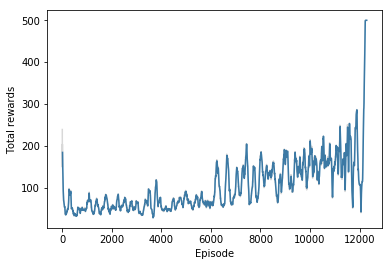

In [161]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

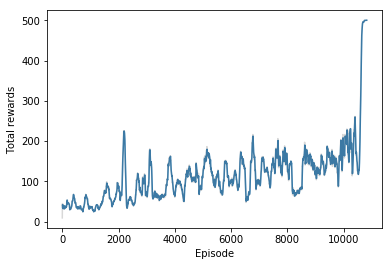

In [146]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

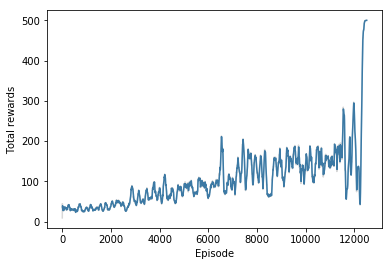

In [131]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

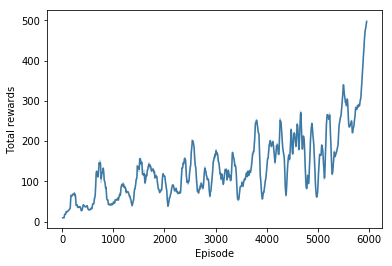

In [116]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

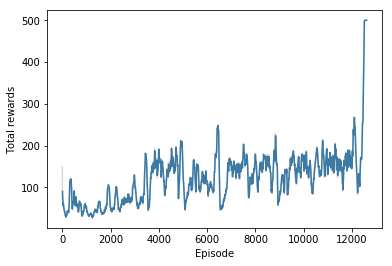

In [98]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

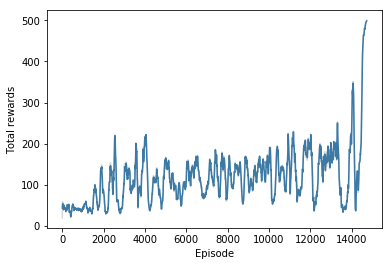

In [70]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

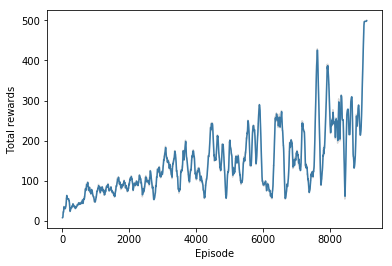

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

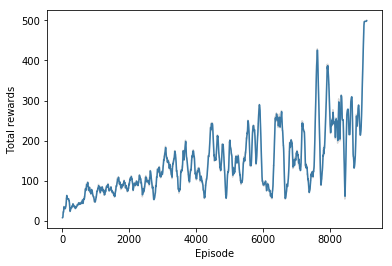

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

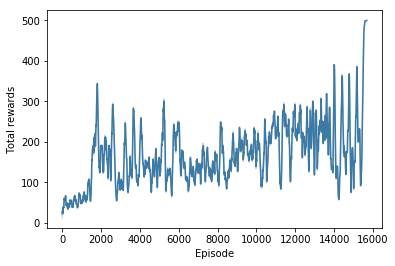

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

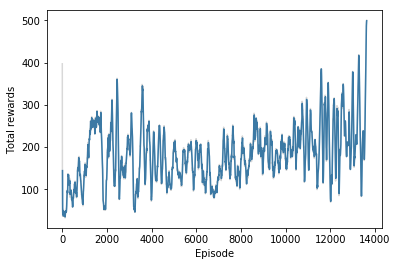

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

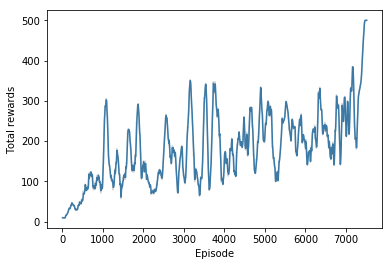

Text(0,0.5,'G losses')

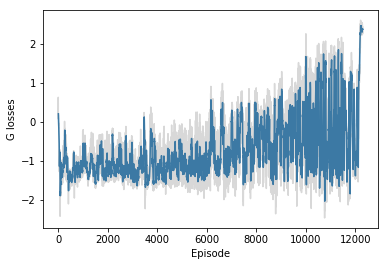

In [162]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

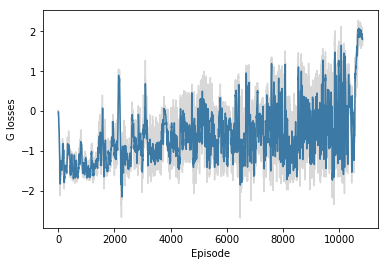

In [147]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

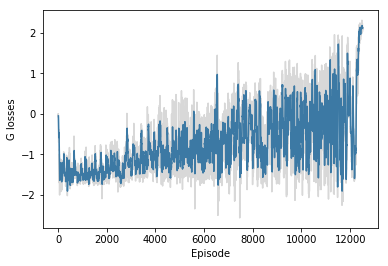

In [132]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

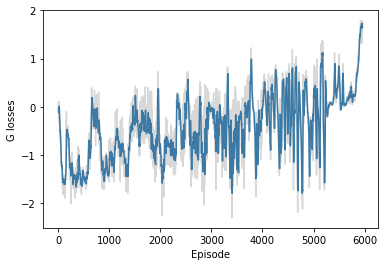

In [117]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

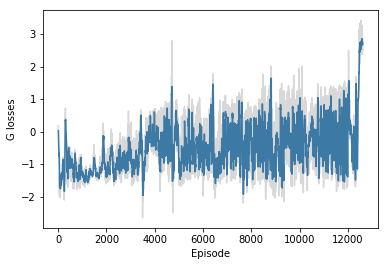

In [99]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

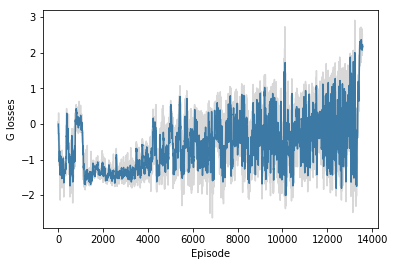

In [83]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

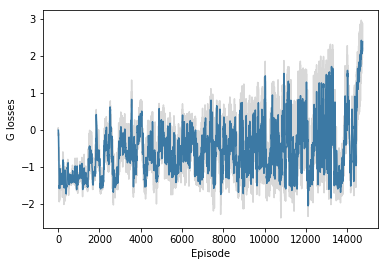

In [71]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

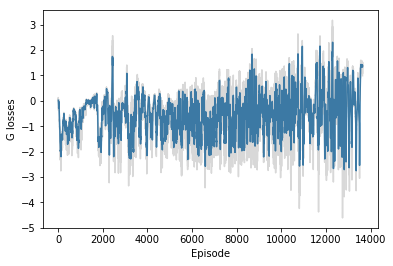

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

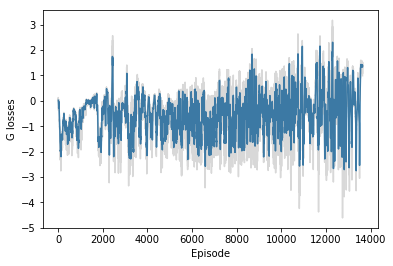

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

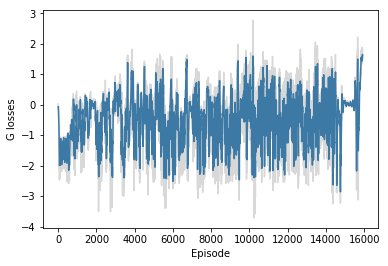
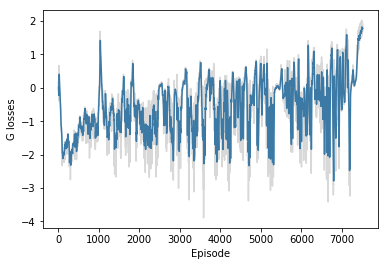

Text(0,0.5,'D losses')

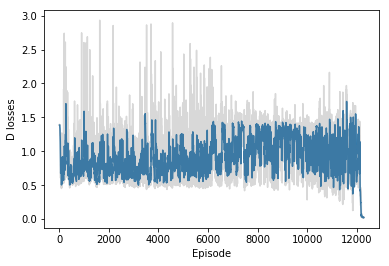

In [163]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

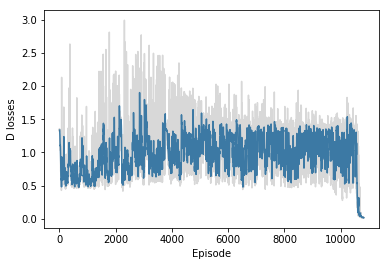

In [148]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

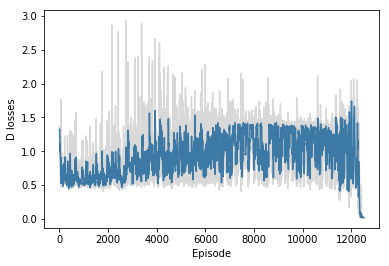

In [133]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

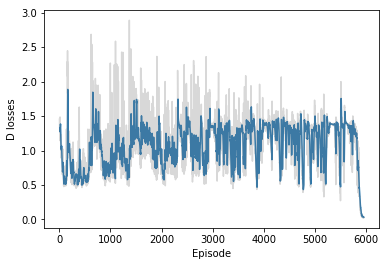

In [118]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

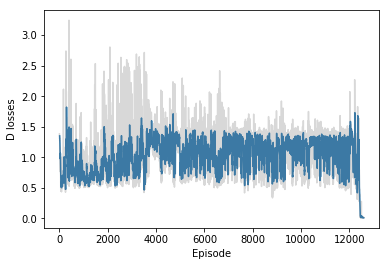

In [100]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

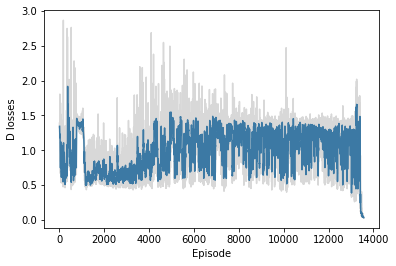

In [84]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

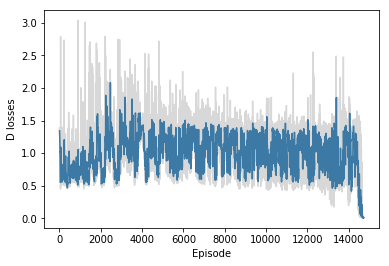

In [72]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

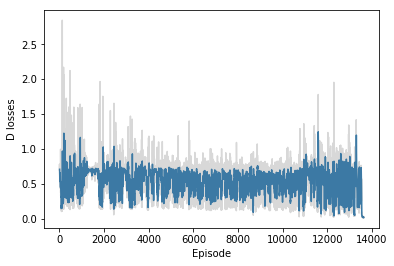

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

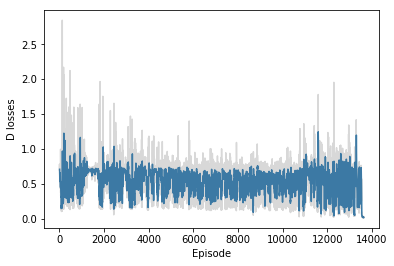

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

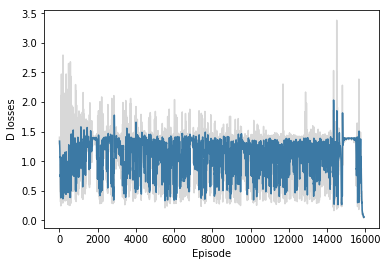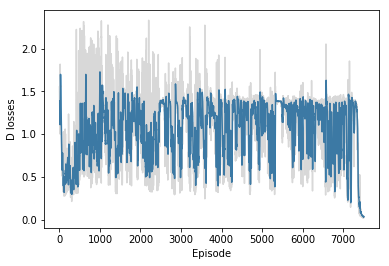

Text(0,0.5,'D losses R')

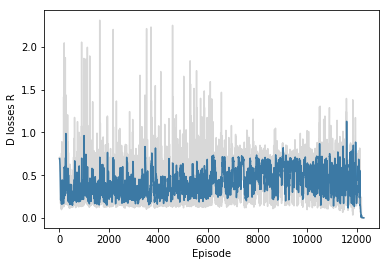

In [164]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

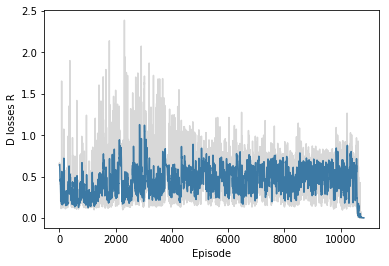

In [149]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

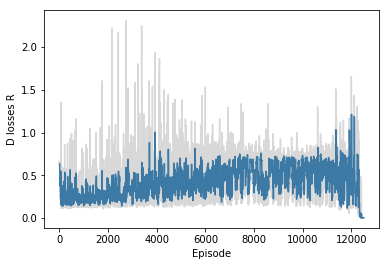

In [134]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

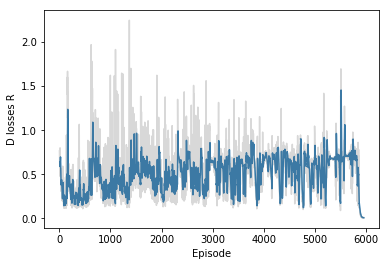

In [119]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

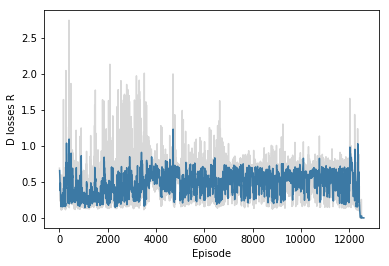

In [101]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

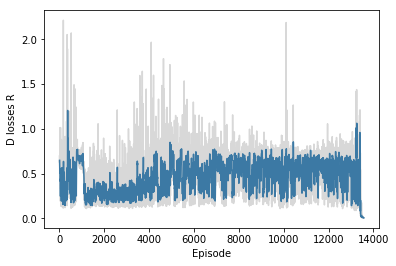

In [85]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

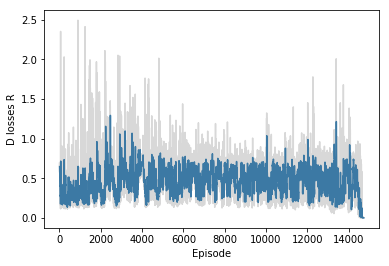

In [73]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

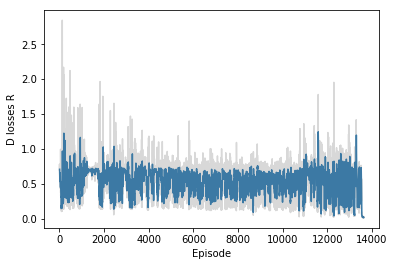

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

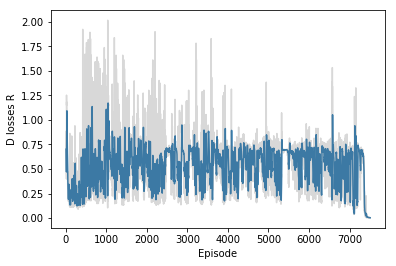

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

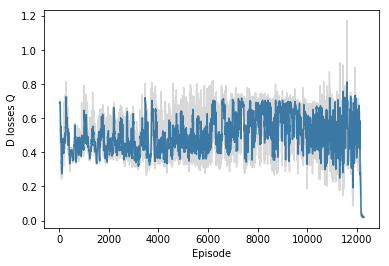

In [165]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

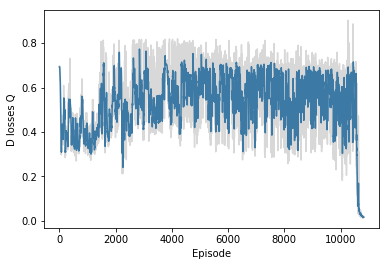

In [150]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

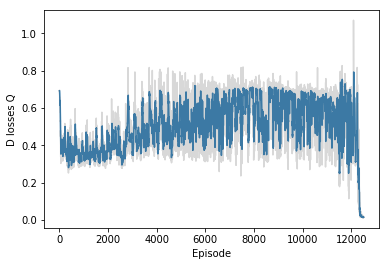

In [135]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

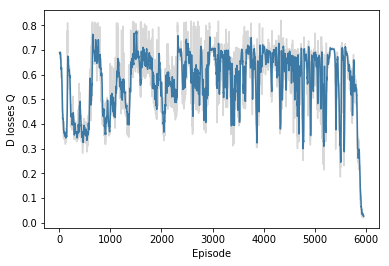

In [120]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

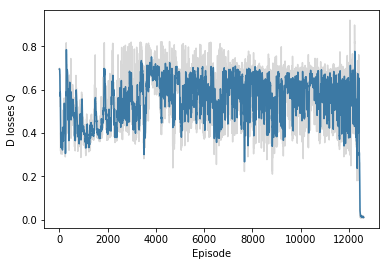

In [102]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

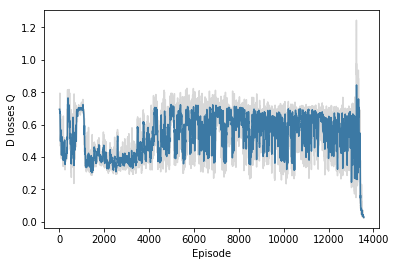

In [86]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

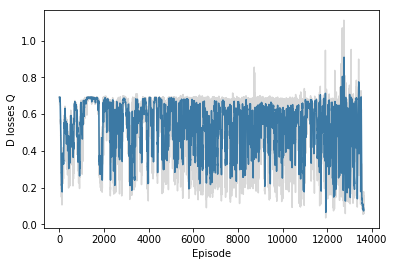

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

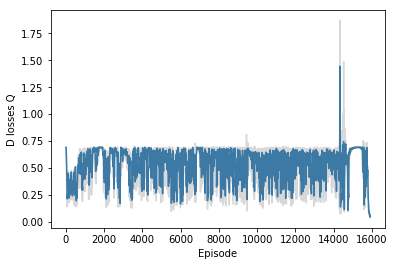

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

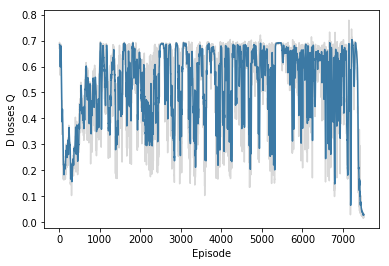

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'Success rates')

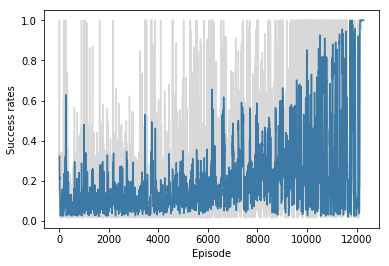

In [166]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.